# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


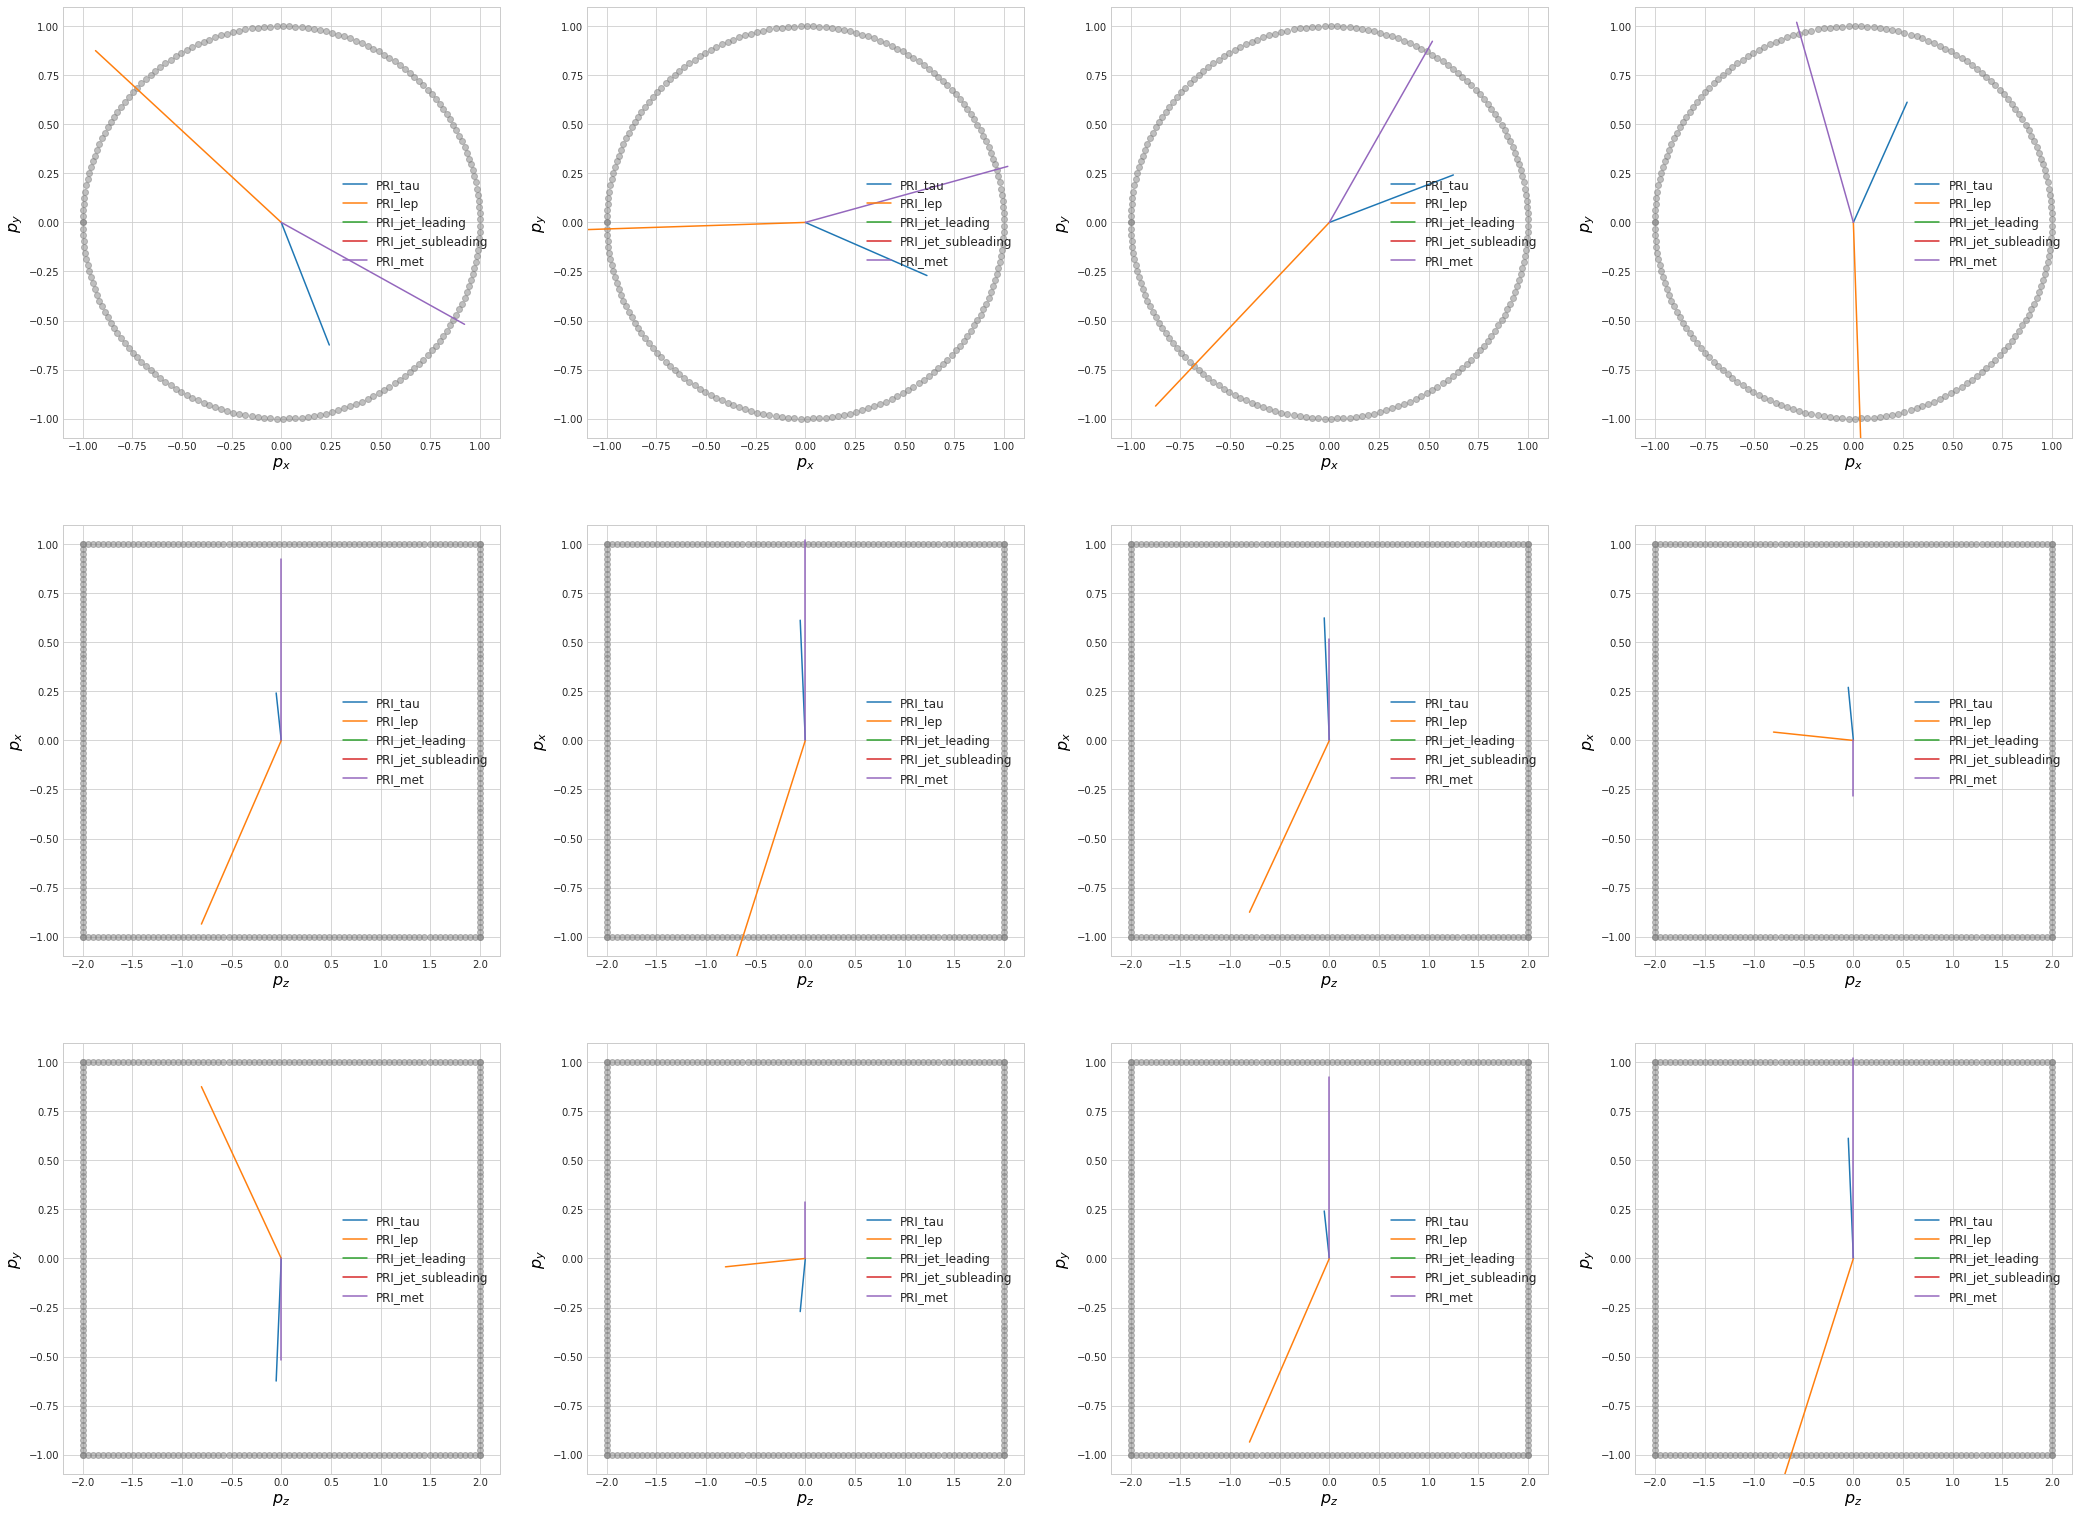

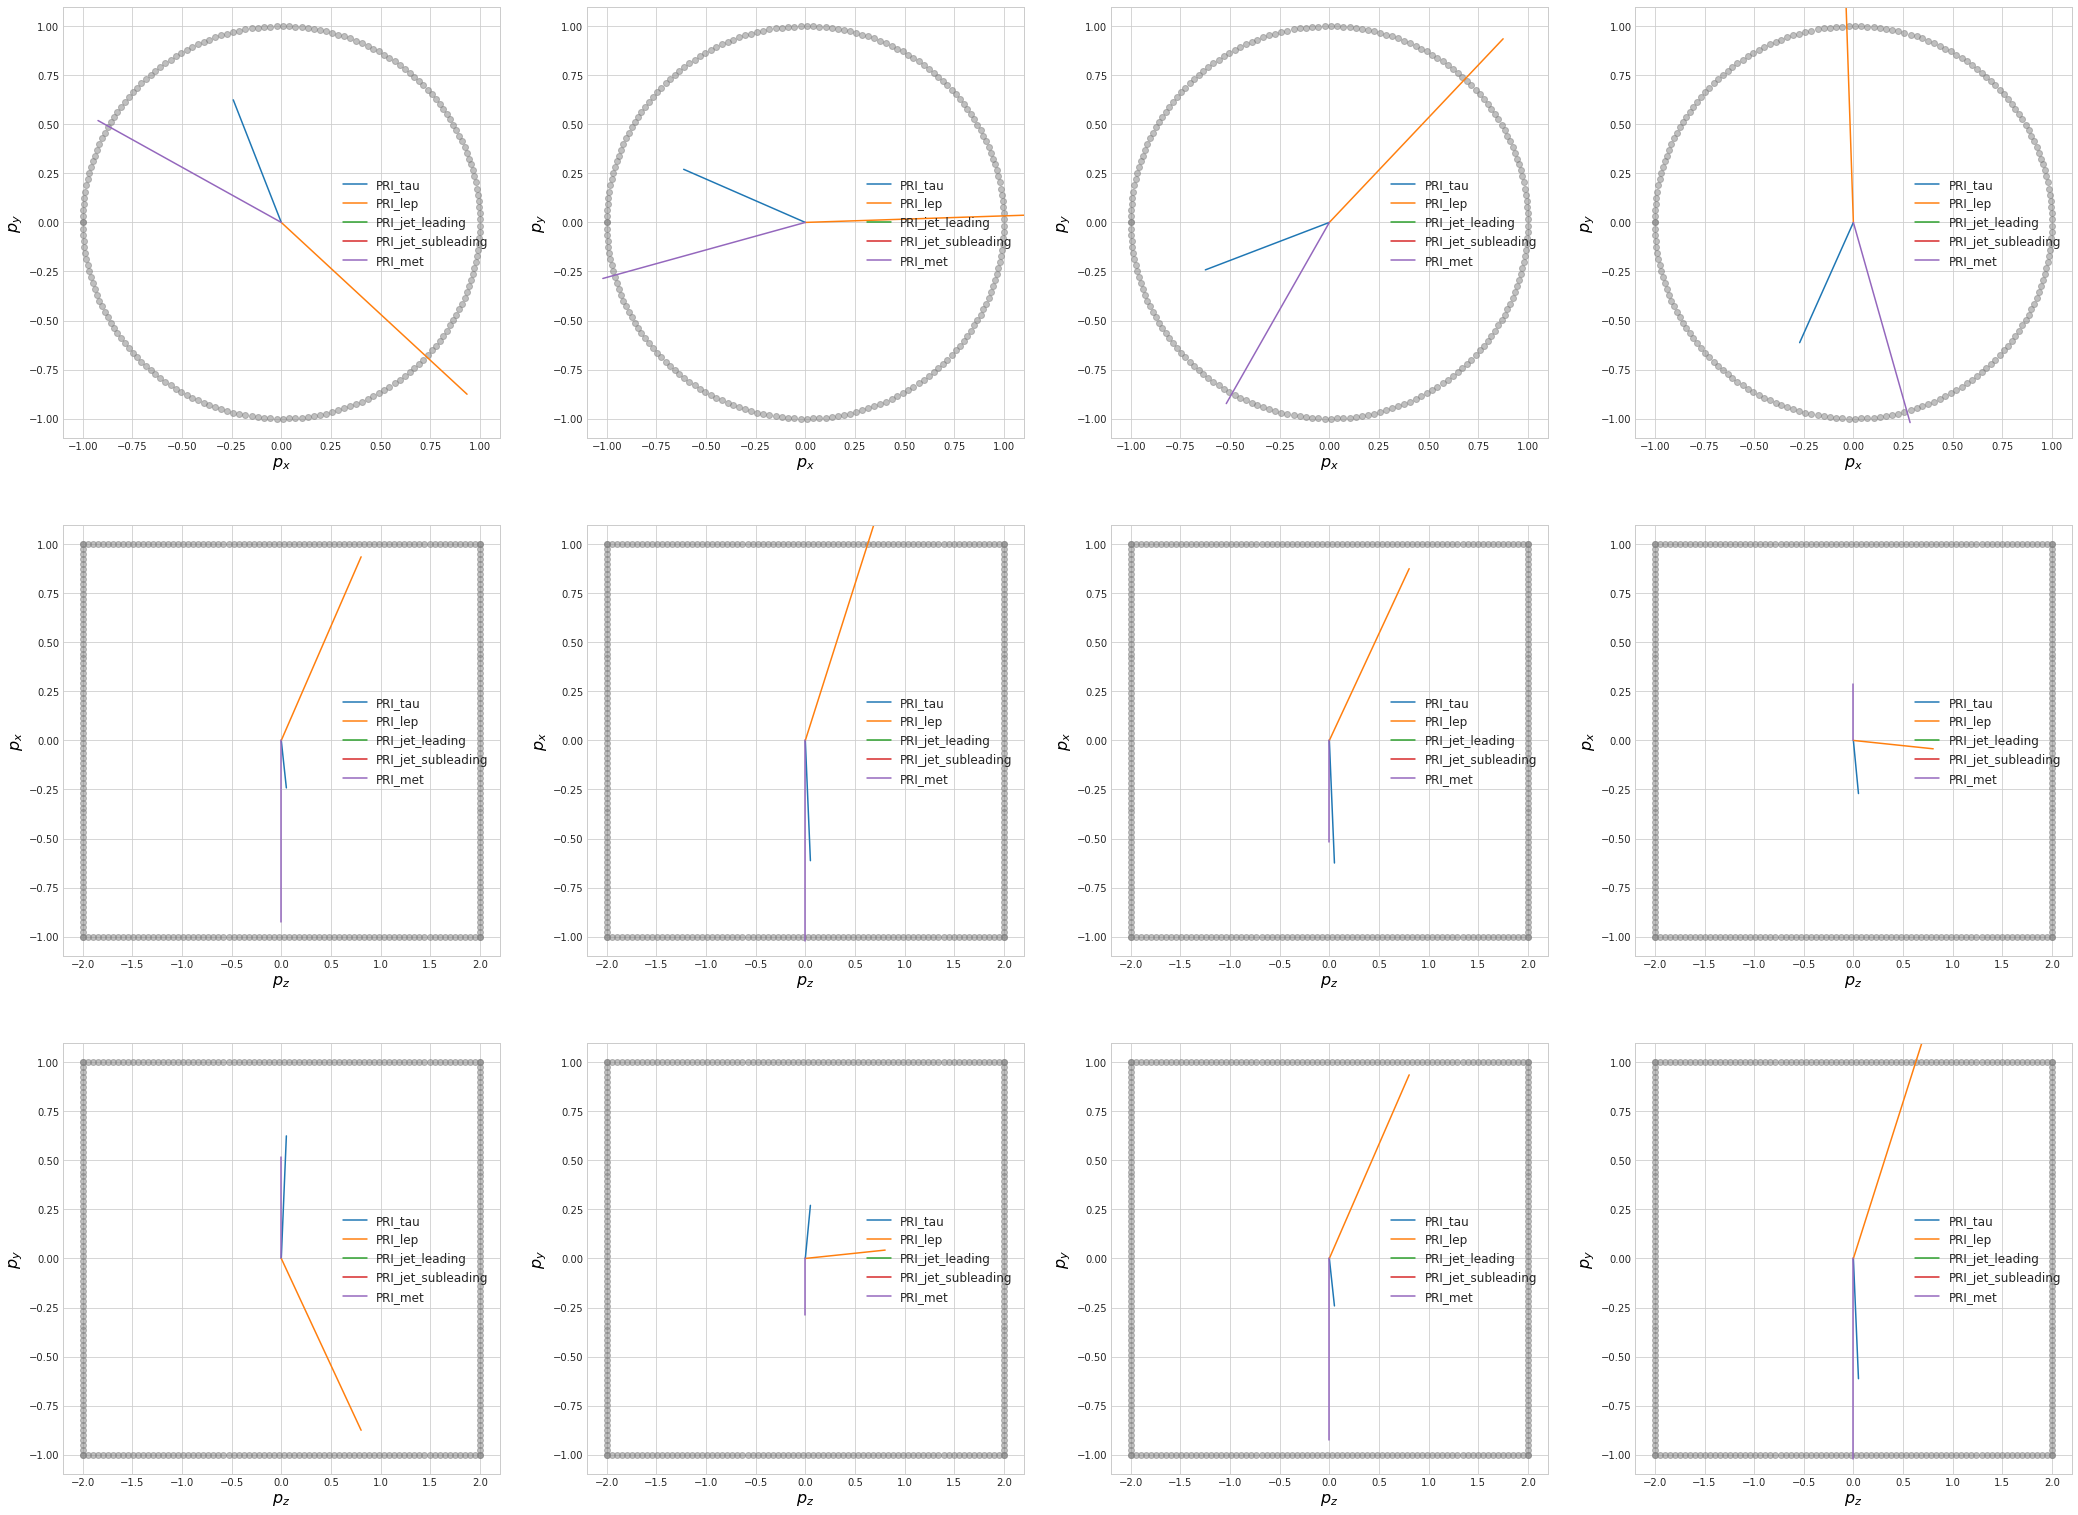

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.832s 


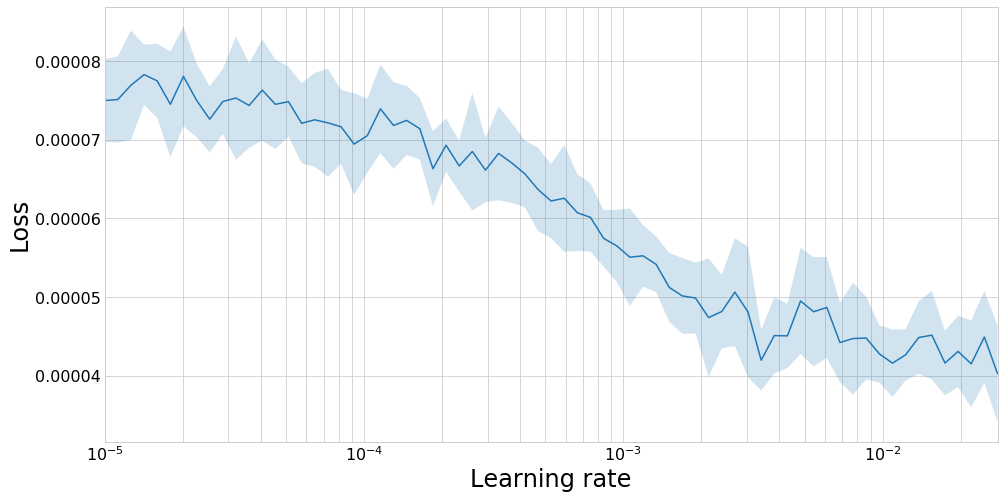

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293720). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147324). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.927683663641801e-05
2 New best found: 3.621992005209904e-05
Saving snapshot 2
3 New best found: 3.541604220372392e-05
4 New best found: 3.498017582460307e-05
5 New best found: 3.4782715293113145e-05
6 New best found: 3.366945868183393e-05
Saving snapshot 3
7 New best found: 3.356092810863629e-05
9 New best found: 3.354628412926104e-05
10 New best found: 3.3180318224185614e-05
11 New best found: 3.2886038845754226e-05
12 New best found: 3.2697705677128395e-05
13 New best found: 3.253489252529107e-05
14 New best found: 3.249889970029471e-05
Saving snapshot 4
15 New best found: 3.247241473000031e-05
24 New best found: 3.217214421165408e-05
26 New best found: 3.20541229652008e-05
28 New best found: 3.187797755090287e-05
29 New best found: 3.182283894129796e-05
30 New best found: 3.176995061076013e-05
Saving snapshot 5
31 New best found: 3.176948376203654e-05
49 New best found: 3.166796755685937e-05
50 New best found: 3.1566170374571814e-05
52 New best 

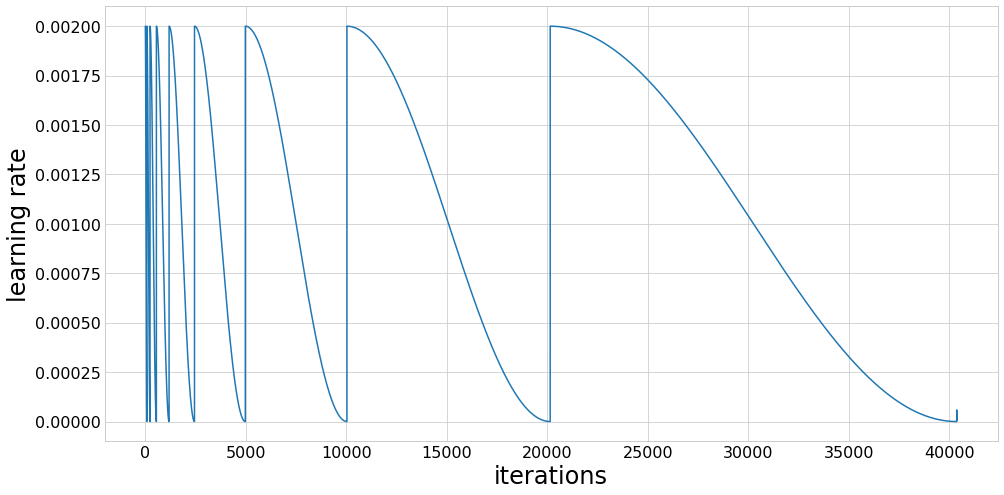

Fold took 453.651s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239456). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120048). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9563686525497015e-05
2 New best found: 3.6784623481673474e-05
Saving snapshot 2
3 New best found: 3.621321010239565e-05
5 New best found: 3.517922817584056e-05
6 New best found: 3.45492056384196e-05
Saving snapshot 3
7 New best found: 3.441444687634903e-05
10 New best found: 3.4231760121487825e-05
11 New best found: 3.3797647278432766e-05
12 New best found: 3.329153841103059e-05
14 New best found: 3.3238823232688354e-05
Saving snapshot 4
15 New best found: 3.3202181214906584e-05
22 New best found: 3.316611503892697e-05
24 New best found: 3.2997038093029256e-05
25 New best found: 3.290209426355527e-05
26 New best found: 3.286471625823058e-05
27 New best found: 3.267984107020541e-05
28 New best found: 3.25294359523957e-05
29 New best found: 3.2498574613904296e-05
Saving snapshot 5
48 New best found: 3.245808805710267e-05
51 New best found: 3.239846124565073e-05
52 New best found: 3.2331566702193106e-05
53 New best found: 3.216051555067694e-05
57 New 

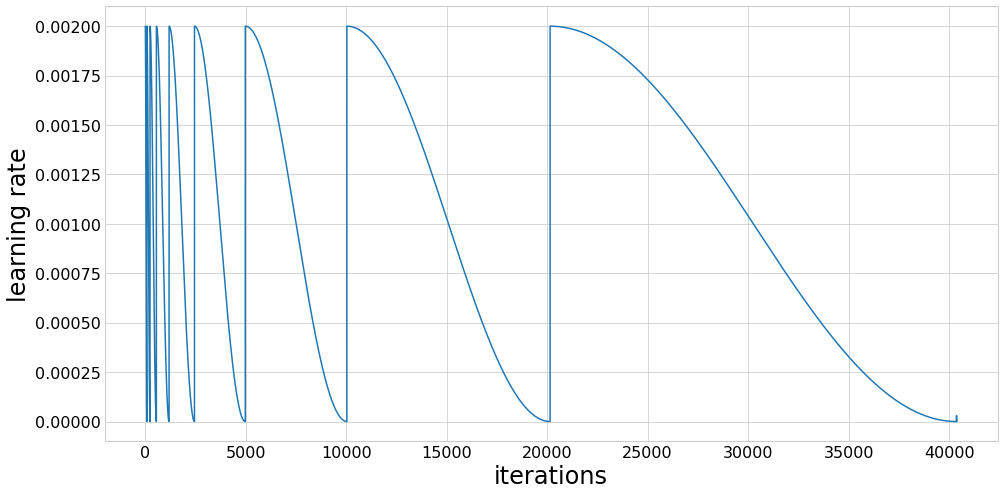

Fold took 468.721s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266513). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133584). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9578003243822e-05
2 New best found: 3.62323003482531e-05
Saving snapshot 2
3 New best found: 3.5170862182709643e-05
4 New best found: 3.510313507091186e-05
5 New best found: 3.400418020326135e-05
6 New best found: 3.349558084631188e-05
Saving snapshot 3
7 New best found: 3.3435347359827616e-05
11 New best found: 3.301151467386419e-05
13 New best found: 3.260935952512101e-05
14 New best found: 3.25112203301972e-05
Saving snapshot 4
15 New best found: 3.2487193655159795e-05
23 New best found: 3.243660491645056e-05
25 New best found: 3.2221300134649944e-05
26 New best found: 3.2070484181543454e-05
27 New best found: 3.191624706454433e-05
29 New best found: 3.1887104455842076e-05
30 New best found: 3.188358637571379e-05
Saving snapshot 5
31 New best found: 3.187122185513641e-05
51 New best found: 3.1813443448799784e-05
52 New best found: 3.1788747210029664e-05
53 New best found: 3.1682527623866905e-05
54 New best found: 3.163324891479561e-05
56 New bes

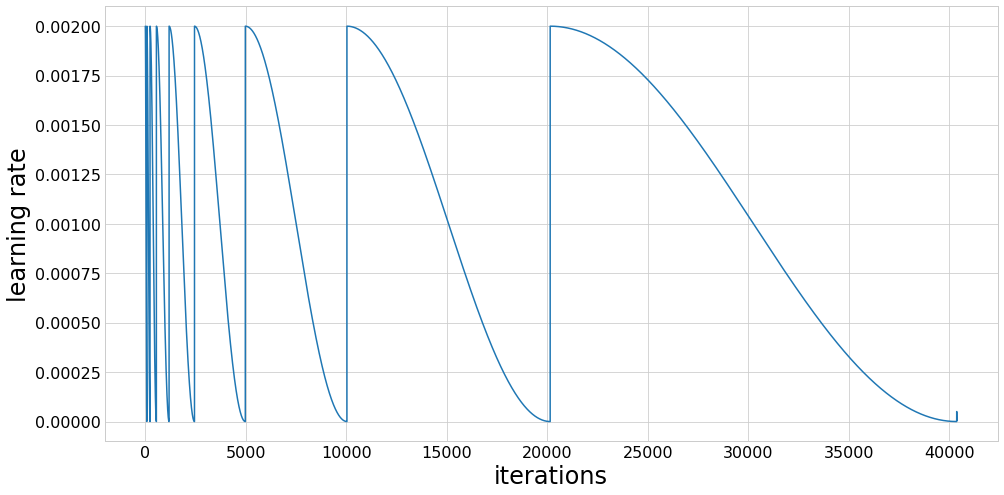

Fold took 468.106s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.322819). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161971). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.121292761992663e-05
2 New best found: 3.8441648722800894e-05
Saving snapshot 2
3 New best found: 3.785155324876541e-05
5 New best found: 3.7327284314960704e-05
6 New best found: 3.63216086072498e-05
Saving snapshot 3
7 New best found: 3.621352969348664e-05
10 New best found: 3.604951653396711e-05
11 New best found: 3.560591846762691e-05
12 New best found: 3.520552117261104e-05
14 New best found: 3.5145285101316405e-05
Saving snapshot 4
15 New best found: 3.510797078197356e-05
21 New best found: 3.508531587140169e-05
22 New best found: 3.4648975750315e-05
24 New best found: 3.455951277574059e-05
26 New best found: 3.4347956352576146e-05
27 New best found: 3.432541276415577e-05
28 New best found: 3.422744082927238e-05
29 New best found: 3.420558435318526e-05
30 New best found: 3.419660197250778e-05
Saving snapshot 5
31 New best found: 3.419634916645009e-05
51 New best found: 3.411610467737773e-05
53 New best found: 3.4061664548062254e-05
54 New best 

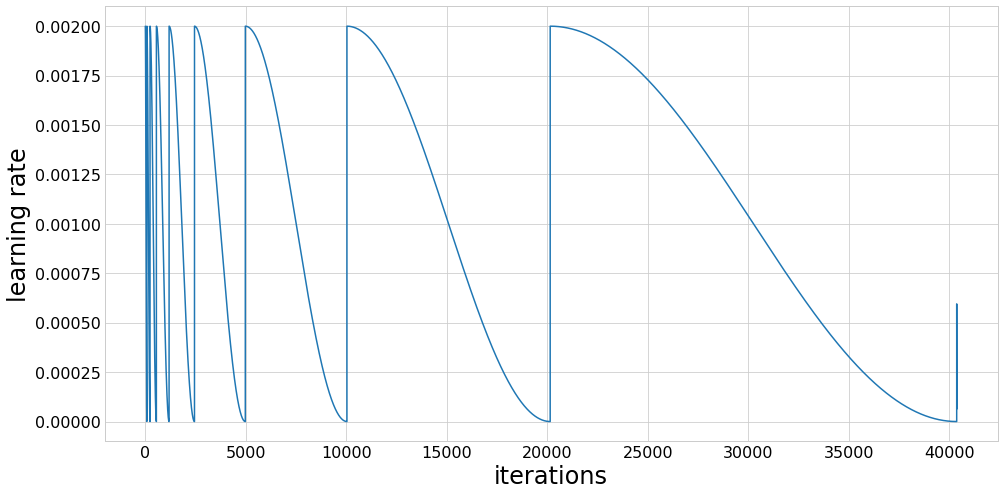

Fold took 480.244s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290764). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145744). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.8983543991348125e-05
2 New best found: 3.596007837957977e-05
Saving snapshot 2
3 New best found: 3.545997362365052e-05
5 New best found: 3.46379001989121e-05
6 New best found: 3.406048688355549e-05
Saving snapshot 3
7 New best found: 3.404620276879423e-05
10 New best found: 3.3801781704413606e-05
11 New best found: 3.3666343643594665e-05
12 New best found: 3.324861640301867e-05
13 New best found: 3.308966997397439e-05
14 New best found: 3.305165351806134e-05
Saving snapshot 4
15 New best found: 3.3031302956411256e-05
23 New best found: 3.300995317693604e-05
24 New best found: 3.2694212486113e-05
26 New best found: 3.258749595758102e-05
27 New best found: 3.25248538133583e-05
28 New best found: 3.2390192008018006e-05
30 New best found: 3.2372650131526753e-05
Saving snapshot 5
31 New best found: 3.237257297030729e-05
46 New best found: 3.236728596005957e-05
47 New best found: 3.2278319207135007e-05
49 New best found: 3.208445191112573e-05
52 New best

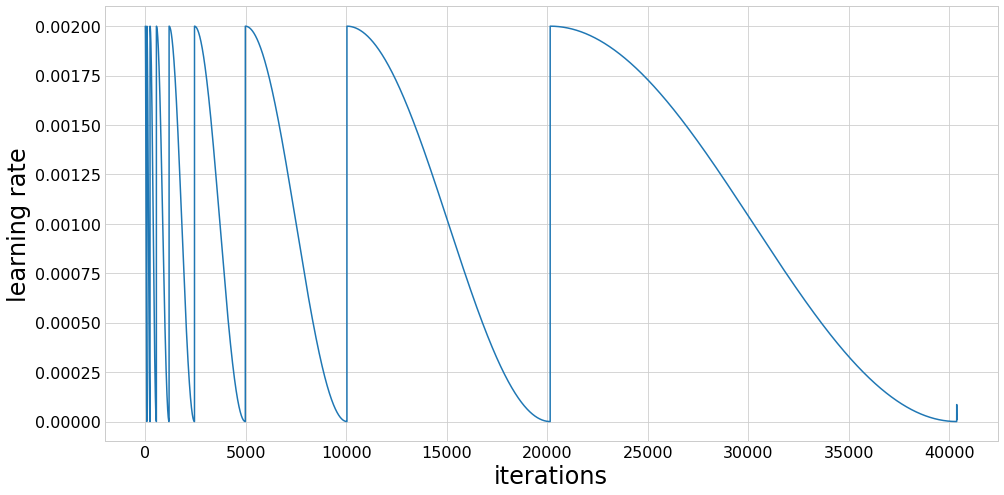

Fold took 493.012s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.326992). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163849). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.8631861759368214e-05
2 New best found: 3.648629551490435e-05
Saving snapshot 2
3 New best found: 3.569914353763221e-05
4 New best found: 3.524935350970079e-05
5 New best found: 3.462032883217527e-05
6 New best found: 3.411982263368024e-05
Saving snapshot 3
7 New best found: 3.387282836541333e-05
11 New best found: 3.370104118597065e-05
12 New best found: 3.3473364052906476e-05
13 New best found: 3.300691062031656e-05
14 New best found: 3.3000429475574945e-05
Saving snapshot 4
15 New best found: 3.297307850503875e-05
24 New best found: 3.295303606493344e-05
25 New best found: 3.2881521653844055e-05
26 New best found: 3.277691493063179e-05
27 New best found: 3.260260394982372e-05
29 New best found: 3.251193367819363e-05
30 New best found: 3.250428635032198e-05
Saving snapshot 5
31 New best found: 3.249915299123162e-05
50 New best found: 3.2478666381636744e-05
51 New best found: 3.231913782036978e-05
56 New best found: 3.218358993259946e-05
59 New bes

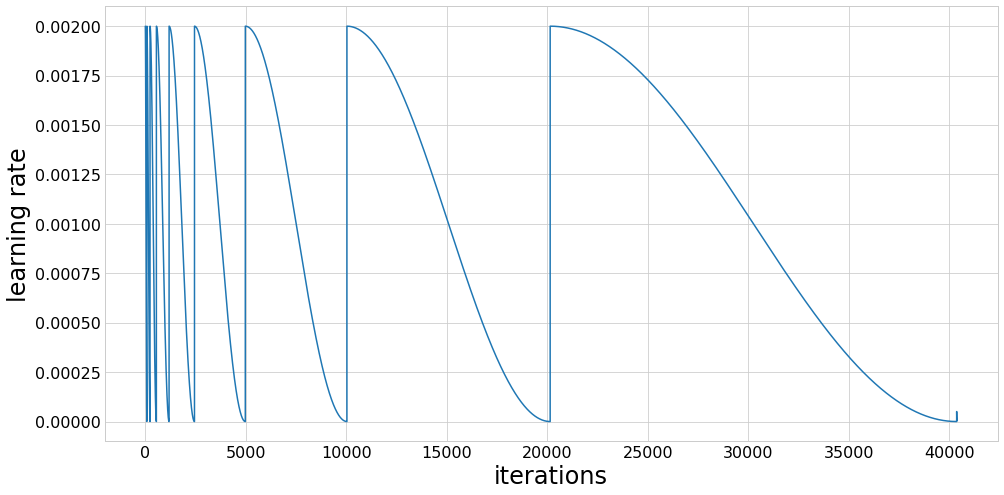

Fold took 501.276s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.343957). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172350). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.915311153396033e-05
2 New best found: 3.6536445439560336e-05
Saving snapshot 2
3 New best found: 3.5647383953619284e-05
4 New best found: 3.5296932481287514e-05
5 New best found: 3.4641688251576854e-05
6 New best found: 3.405855500022881e-05
Saving snapshot 3
7 New best found: 3.3954009918670635e-05
9 New best found: 3.382755834318232e-05
11 New best found: 3.341894147743005e-05
12 New best found: 3.313933326426195e-05
14 New best found: 3.296528334612958e-05
Saving snapshot 4
15 New best found: 3.2925680620246565e-05
21 New best found: 3.2898179542826254e-05
22 New best found: 3.278904322141898e-05
24 New best found: 3.253773954565986e-05
25 New best found: 3.2504038789920744e-05
27 New best found: 3.249475736956811e-05
28 New best found: 3.237459007359576e-05
29 New best found: 3.2347605718678096e-05
30 New best found: 3.233338033314794e-05
Saving snapshot 5
31 New best found: 3.232890298968414e-05
50 New best found: 3.219850109453546e-05
51 New 

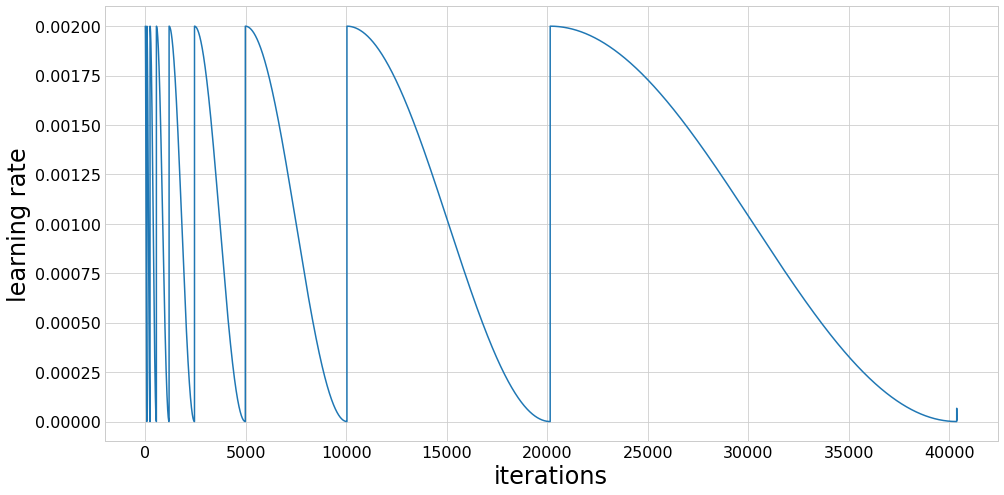

Fold took 507.215s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.374838). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188042). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9467884455512715e-05
2 New best found: 3.6512691240371615e-05
Saving snapshot 2
3 New best found: 3.5973974223784065e-05
4 New best found: 3.560591174996322e-05
5 New best found: 3.4727290435290125e-05
6 New best found: 3.4345863558719484e-05
Saving snapshot 3
7 New best found: 3.4269963490290094e-05
9 New best found: 3.3923964858339696e-05
11 New best found: 3.367455739312213e-05
12 New best found: 3.364302726630295e-05
13 New best found: 3.335448637676633e-05
14 New best found: 3.3229164283977227e-05
Saving snapshot 4
15 New best found: 3.3207615424019447e-05
22 New best found: 3.320377827117589e-05
23 New best found: 3.315353755296922e-05
24 New best found: 3.302120769473852e-05
25 New best found: 3.290904820148482e-05
27 New best found: 3.270633280772704e-05
Saving snapshot 5
31 New best found: 3.2695689896623e-05
50 New best found: 3.249918893192221e-05
54 New best found: 3.243541437969328e-05
55 New best found: 3.23957516188144e-05
57 New bes

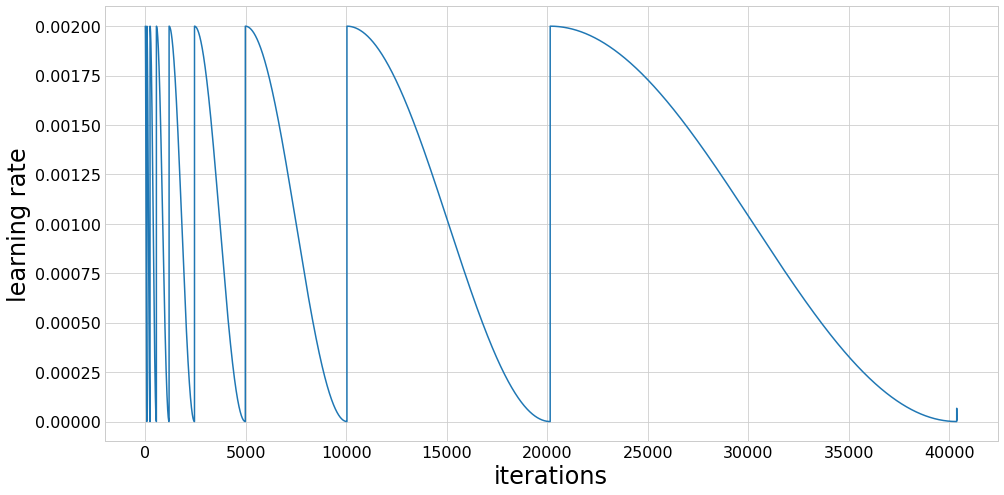

Fold took 516.297s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.434842). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217806). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.0819590671954534e-05
2 New best found: 3.6905487290123156e-05
Saving snapshot 2
3 New best found: 3.625097807012451e-05
5 New best found: 3.56351984960336e-05
6 New best found: 3.496707579513777e-05
Saving snapshot 3
7 New best found: 3.4889639648418675e-05
10 New best found: 3.4646086526845774e-05
11 New best found: 3.439908191050811e-05
12 New best found: 3.407491760767129e-05
13 New best found: 3.39699734132972e-05
14 New best found: 3.376580461491379e-05
Saving snapshot 4
15 New best found: 3.3758877764301244e-05
25 New best found: 3.357418853321699e-05
26 New best found: 3.336151415811687e-05
28 New best found: 3.33511232480391e-05
29 New best found: 3.331691462817456e-05
30 New best found: 3.3307242219320445e-05
Saving snapshot 5
31 New best found: 3.3305338511720005e-05
51 New best found: 3.3252079665851836e-05
53 New best found: 3.3208942095599e-05
54 New best found: 3.320859295692579e-05
55 New best found: 3.307047112027554e-05
59 New best

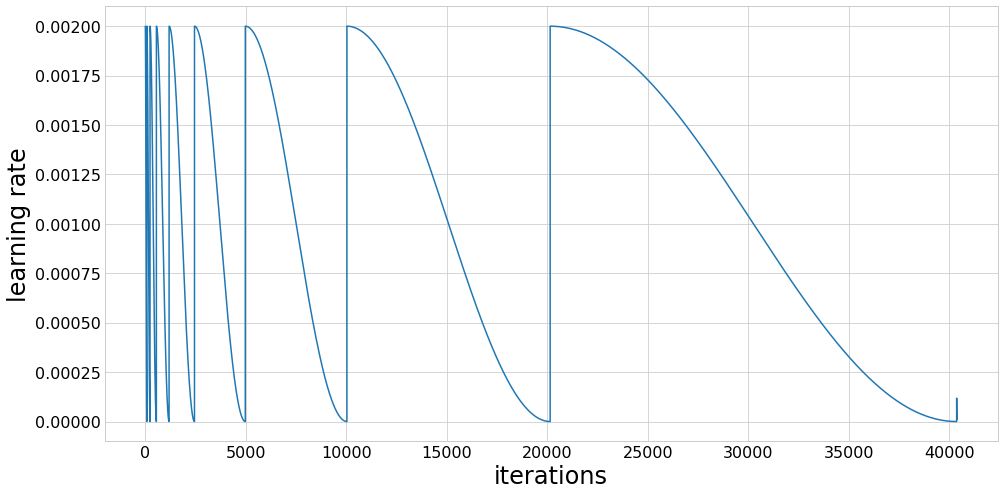

Fold took 520.872s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.429413). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215091). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9728438947349785e-05
2 New best found: 3.736664160678629e-05
Saving snapshot 2
3 New best found: 3.582734663214069e-05
5 New best found: 3.454083119431743e-05
6 New best found: 3.436436603224138e-05
Saving snapshot 3
7 New best found: 3.42572488982114e-05
10 New best found: 3.390255753038218e-05
12 New best found: 3.331110990257002e-05
13 New best found: 3.3155377164075616e-05
14 New best found: 3.304308014921844e-05
Saving snapshot 4
15 New best found: 3.3023260407207996e-05
22 New best found: 3.301129599130945e-05
25 New best found: 3.2884174438368066e-05
26 New best found: 3.2627446041442454e-05
27 New best found: 3.252501350652892e-05
30 New best found: 3.2501489379501433e-05
Saving snapshot 5
31 New best found: 3.249609121558024e-05
49 New best found: 3.229119365132647e-05
53 New best found: 3.2133273484942035e-05
58 New best found: 3.208041967300233e-05
59 New best found: 3.207721570142894e-05
Saving snapshot 6
99 New best found: 3.2009218647

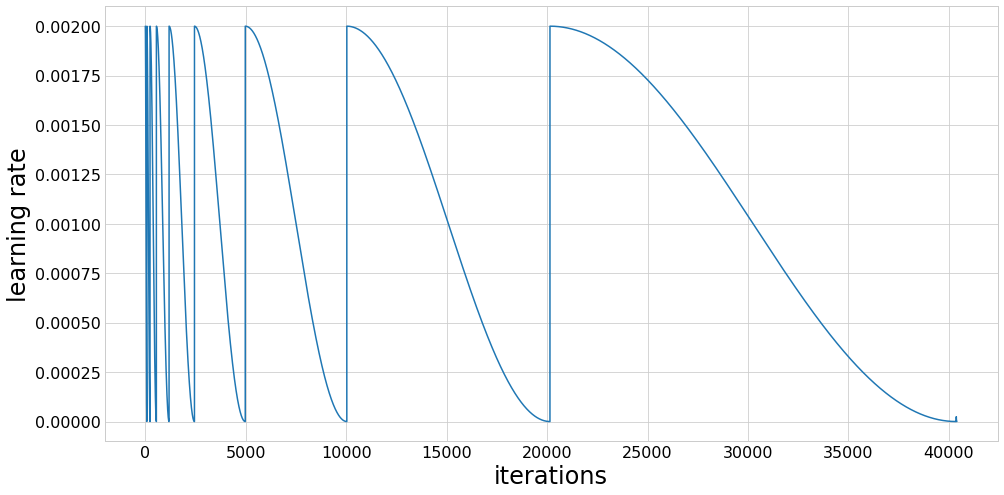

Fold took 546.653s


______________________________________
Training finished
Cross-validation took 4956.215s 


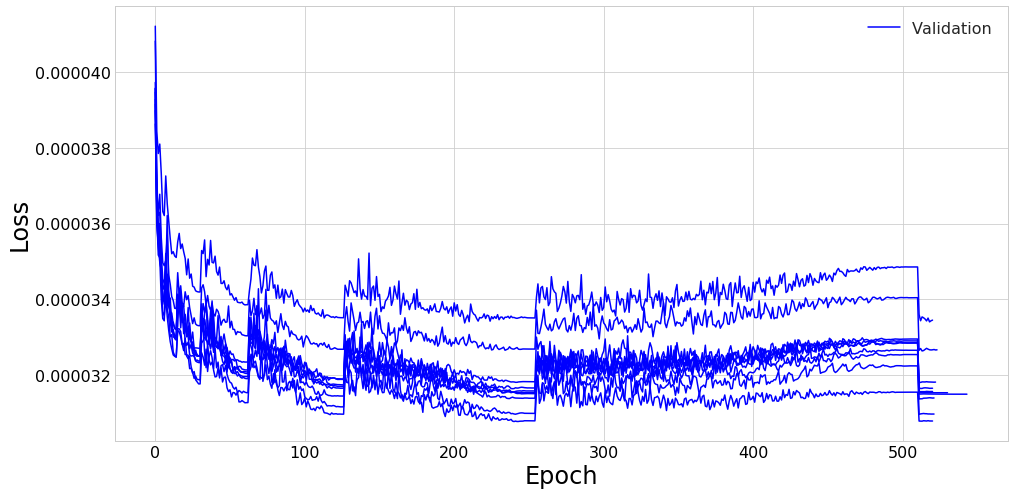

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0631 +- 0.0009
Mean AUC = 0.0983 +- 0.0008
Mean AMS = 3.95 +- 0.09
Mean cut = 0.969 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [8]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [4]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [5]:
ensemble, weights = assemble_ensemble(results, 10, ensemble_mode, compile_args, weighting='reciprocal')


Choosing ensemble by loss
Model 0 is 0 with loss = 3.077631727937842e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 1 is 2 with loss = 3.0965693401774725e-05
Model 2 is 4 with loss = 3.1370671649972326e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 3 is 9 with loss = 3.1498063166509386e-05
Model 4 is 1 with loss = 3.153547038938907e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 5 is 6 with loss = 3.1557824897026875e-05
Model 6 is 7 with loss = 3.1643318048500156e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 7 is 5 with loss = 3.180839154176106e-05
Model 8 is 8 with loss = 3.263965910765749e-05
Model 9 is 3 with loss = 3.337828800140414e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
def test_ensemble(weighting, size, rot_mult):
    ensemble, weights = assemble_ensemble(results, size, ensemble_mode, compile_args, weighting=weighting, verbose=0)
    val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=rot_mult)
    fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=0)
    val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')
    ams, cut = ams_scan_slow(val_df_tta, br=10, w_factor=250000/50000)
    print(weighting, size, rot_mult, ams, cut)

In [12]:
for weighting in ['reciprocal', 'uniform']:
    for size in [1,3,5,10]:
        for rot_mult in [1,2,4,8,16]:
            print('__________________________________')
            test_ensemble(weighting, size, rot_mult)
            print('__________________________________\n')

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 1 1 3.760107067374803 0.96137065
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 1 2 3.8561922758413023 0.96229804
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 1 4 3.8353796942887333 0.9645092
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 1 8 3.8023868256661233 0.96497583
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 1 16 3.81741641008192 0.96367085
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 3 1 3.82711253184953 0.9617308
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 3 2 3.92795727642298 0.9620445
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 3 4 3.8965046184781595 0.9629502
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 3 8 3.8978593745651993 0.9630989
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 3 16 3.904263776056905 0.96333075
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 5 1 3.899712703615233 0.95648056
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 5 2 3.949322201592021 0.9625035
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 5 4 3.9463191969599665 0.9583566
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 5 8 3.9430135837277818 0.9589466
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 5 16 3.9461536471374132 0.96238476
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 10 1 3.918535930470454 0.96000415
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 10 2 3.950366909002707 0.9597334
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 10 4 3.9427988443415676 0.95969284
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 10 8 3.9444816143250288 0.9596084
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 10 16 3.9406606725385336 0.9596132
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 1 1 3.760107067374803 0.96137065
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 1 2 3.8561922758413023 0.96229804
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 1 4 3.8353796942887333 0.9645092
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 1 8 3.8023868256661233 0.96497583
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 1 16 3.81741641008192 0.96367085
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 3 1 3.829369990998786 0.9617021
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 3 2 3.9221067063024035 0.96204686
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 3 4 3.8973195837756562 0.962894
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 3 8 3.89521430048222 0.9631197
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 3 16 3.896827104203383 0.9633102
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 5 1 3.8981685643229906 0.9567567
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 5 2 3.9496022453780415 0.96266687
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 5 4 3.9470372642302545 0.95833796
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 5 8 3.9450518771478893 0.958906
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 5 16 3.9481744054257923 0.9623698
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 10 1 3.9215370684742195 0.9599593
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 10 2 3.9529265300678635 0.9596955
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 10 4 3.9427624195753723 0.95969325
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 10 8 3.9408728955656986 0.9596538
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in s

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 10 16 3.935495020901147 0.96034604
__________________________________



## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [16]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [17]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017228627920150756s per sample

Predicting fold 2 out of 10
Prediction took 0.0017207252660766245s per sample

Predicting fold 3 out of 10
Prediction took 0.0017178760144859553s per sample

Predicting fold 4 out of 10
Prediction took 0.0017281460037454962s per sample

Predicting fold 5 out of 10
Prediction took 0.0017102207619696856s per sample

Predicting fold 6 out of 10
Prediction took 0.0017026645727455617s per sample

Predicting fold 7 out of 10
Prediction took 0.0017033471316099168s per sample

Predicting fold 8 out of 10
Prediction took 0.001713594409264624s per sample

Predicting fold 9 out of 10
Prediction took 0.0017070972697809338s per sample

Predicting fold 10 out of 10
Prediction took 0.0017042697167024016s per sample



In [18]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9037904707372353, weighted 0.9363405314219806


Best cut at 0.9580914527923614 corresponds to AMS of 3.8754732082383265
Maximum AMS for data is 3.9362918975421217 at cut of 0.9597761034965515
CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 23.9 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


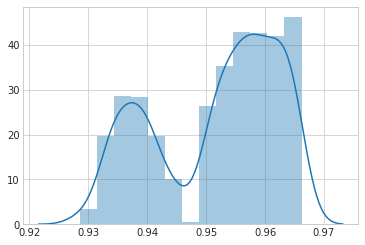

In [20]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95173985 corresponds to AMS of 3.813569635736365
Maximum AMS for data is 3.9362918975421217 at cut of 0.9597761034965515
CPU times: user 99.9 ms, sys: 81 ms, total: 181 ms
Wall time: 81.8 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


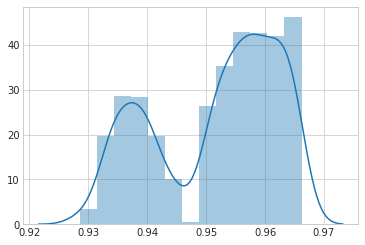

In [21]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [22]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0015842024059288882s per sample

Predicting fold 2 out of 10
Prediction took 0.0015822962979024106s per sample

Predicting fold 3 out of 10
Prediction took 0.001591165615990758s per sample

Predicting fold 4 out of 10
Prediction took 0.0015898005889559334s per sample

Predicting fold 5 out of 10
Prediction took 0.0015869131820784373s per sample

Predicting fold 6 out of 10
Prediction took 0.0015894851312379945s per sample

Predicting fold 7 out of 10
Prediction took 0.001580133654312654s per sample

Predicting fold 8 out of 10
Prediction took 0.0015866630521518264s per sample

Predicting fold 9 out of 10
Prediction took 0.0015855307115411217s per sample

Predicting fold 10 out of 10
Prediction took 0.0015849925438958135s per sample

CPU times: user 17min 34s, sys: 2min 7s, total: 19min 41s
Wall time: 14min 32s


In [24]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.776866644695453 : 3.814839090226531


(3.776866644695453, 3.814839090226531)

In [25]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.8065494769301567 : 3.825416657821372


(3.8065494769301567, 3.825416657821372)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)